In [180]:
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


### Activation Functions

In [181]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z)) 
    return A


def softmax(z):
    # Subtract the maximum value in z for numerical stability
    shift_z = z - np.max(z, axis=0, keepdims=True)
    exp_z = np.exp(shift_z)
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

def relu(Z):
    A = np.maximum(0,Z)
    return A

def tanh(x):
    return np.tanh(x)

def derivative_relu(Z):
    return np.array(Z > 0, dtype = 'float')

def derivative_tanh(x):
    return (1 - np.power(x, 2))

In [182]:
# initial_weights = pd.read_csv('Task_1/b/w-100-40-4.csv', header=None)
initial_weights = pd.read_csv('Task_1/a/w.csv', header=None)

In [183]:
# initial_biases 
initial_biases = pd.read_csv('Task_1/a/b.csv', header=None)

In [184]:
w1 = initial_weights.iloc[0:14, 1:].to_numpy().astype(np.float32).T
w2 = initial_weights.iloc[14:114, 1:41].to_numpy().astype(np.float32).T
w3 = initial_weights.iloc[114:, 1:5].to_numpy().astype(np.float32).T

In [185]:
b1 = initial_biases.iloc[0, 1:].to_numpy().astype(np.float32).T
b2 = initial_biases.iloc[1, 1:41].to_numpy().astype(np.float32).T
b3 = initial_biases.iloc[2, 1:5].to_numpy().astype(np.float32).T

In [186]:
# reshape b1s
b1 = b1.reshape(-1,1)
b2 = b2.reshape(-1,1)
b3 = b3.reshape(-1,1)

### Initialize parameters

In [187]:
def initialize_parameters(layer_dims):
    
    parameters = {}
    L = len(layer_dims)            

    parameters['W' + str(1)] = w1
    parameters['b' + str(1)] = b1

    parameters['W' + str(2)] = w2
    parameters['b' + str(2)] = b2

    parameters['W' + str(3)] = w3
    parameters['b' + str(3)] = b3   
        
    return parameters

In [188]:

layer_dims = [14, 100, 40, 4]
params = initialize_parameters(layer_dims)

for l in range(1, len(layer_dims)):
    print("Shape of W" + str(l) + ":", params['W' + str(l)].shape)
    print("Shape of B" + str(l) + ":", params['b' + str(l)].shape, "\n")

Shape of W1: (100, 14)
Shape of B1: (100, 1) 

Shape of W2: (40, 100)
Shape of B2: (40, 1) 

Shape of W3: (4, 40)
Shape of B3: (4, 1) 



In [189]:
len(params)

6

### Forward Propagation

In [190]:
def forward_propagation(X, parameters, activation):
   
    forward_cache = {}
    L = len(parameters) // 2                  
    
    forward_cache['A0'] = X

    for l in range(1, L):
        forward_cache['Z' + str(l)] = parameters['W' + str(l)].dot(forward_cache['A' + str(l-1)]) + parameters['b' + str(l)]
        
        if activation == 'tanh':
            forward_cache['A' + str(l)] = tanh(forward_cache['Z' + str(l)])
        else:
            forward_cache['A' + str(l)] = relu(forward_cache['Z' + str(l)])
            

    forward_cache['Z' + str(L)] = parameters['W' + str(L)].dot(forward_cache['A' + str(L-1)]) + parameters['b' + str(L)]
    
    if forward_cache['Z' + str(L)].shape[0] == 1:
        forward_cache['A' + str(L)] = sigmoid(forward_cache['Z' + str(L)])
    else :
        forward_cache['A' + str(L)] = softmax(forward_cache['Z' + str(L)])
    
    return forward_cache['A' + str(L)], forward_cache

### Cost function

In [191]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    
    if Y.shape[0] == 1:
        cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    else:
        cost = -(1./m) * np.sum(Y * np.log(AL))
        
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    
    return cost

In [192]:
def backward_propagation(AL, Y, parameters, forward_cache, activation):
    
    grads = {}
    L = len(parameters)//2
    m = AL.shape[1]
    
    grads["dZ" + str(L)] = AL - Y  # After derivation of cross entropy loss and softmax activation function
    grads["dW" + str(L)] = 1./m * np.dot(grads["dZ" + str(L)],forward_cache['A' + str(L-1)].T)
    grads["db" + str(L)] = 1./m * np.sum(grads["dZ" + str(L)], axis = 1, keepdims = True)
    
    for l in reversed(range(1, L)):
        if activation == 'tanh':
            grads["dZ" + str(l)] = np.dot(parameters['W' + str(l+1)].T,grads["dZ" + str(l+1)])*derivative_tanh(forward_cache['A' + str(l)])
        else:
            grads["dZ" + str(l)] = np.dot(parameters['W' + str(l+1)].T,grads["dZ" + str(l+1)])*derivative_relu(forward_cache['A' + str(l)])
            
        grads["dW" + str(l)] = 1./m * np.dot(grads["dZ" + str(l)],forward_cache['A' + str(l-1)].T)
        grads["db" + str(l)] = 1./m * np.sum(grads["dZ" + str(l)], axis = 1, keepdims = True)

    return grads

In [193]:
def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2 
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

In [194]:
def predict(X, y, parameters, activation):

    m = X.shape[1]
    y_pred, caches = forward_propagation(X, parameters, activation)
    
    if y.shape[0] == 1:
        y_pred = np.array(y_pred > 0.5, dtype = 'float')
    else:
        y = np.argmax(y, 0)
        y_pred = np.argmax(y_pred, 0)
    
    return np.round(np.sum((y_pred == y)/m), 2)

In [195]:
def model(X, Y, layers_dims, learning_rate = 0.03, activation = 'relu', num_iterations = 3000):

    np.random.seed(1)
    costs = []              
    
    parameters = initialize_parameters(layers_dims)
    # print("parameters", parameters)

    for i in range(0, num_iterations):

        AL, forward_cache = forward_propagation(X, parameters, activation)

        cost = compute_cost(AL, Y)
        costs.append(cost)

        grads = backward_propagation(AL, Y, parameters, forward_cache, activation)

        parameters = update_parameters(parameters, grads, learning_rate)
        

       
    return parameters,grads,costs

In [221]:
X=[-1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1]
y = [0,0,0,1]

# make this suitable for input as NN
X_train = np.array(X).reshape(-1, 1)
Y_train = np.array(y).reshape(-1, 1)

print(X_train.shape, Y_train.shape)

layers_dims = [14, 100, 40, 4]
lr = 0.01
iters = 1

(14, 1) (4, 1)


In [222]:
parameters ,grads , costs= model(X_train, Y_train, layers_dims, learning_rate = lr, activation = 'relu', num_iterations = iters)

In [223]:
parameters

{'W1': array([[ 0.47143516,  0.29120535, -0.31956139, ...,  1.57139599,
         -0.47867355,  1.04069901],
        [-1.13794568,  0.51350369, -0.67302308, ..., -1.35287704,
         -0.47195537, -0.4425982 ],
        [ 1.43270695,  0.50359178,  0.15699838, ...,  0.00726464,
         -1.78277564,  2.47868061],
        ...,
        [ 0.57744689,  0.83999871, -0.41316871, ..., -2.07128291,
          2.05662493, -0.91282989],
        [-1.04520625,  0.26459429, -1.57712489, ..., -2.1685111 ,
         -1.79465454, -0.07050196],
        [-0.5994019 , -0.96401833, -0.23177718, ..., -0.19912185,
         -1.48019611, -0.66331427]]),
 'b1': array([[-0.63515496],
        [-0.73405013],
        [-1.50158572],
        [-0.37922005],
        [-0.35299936],
        [ 0.12738439],
        [ 0.59761002],
        [ 0.75405233],
        [-0.72675111],
        [-0.6326859 ],
        [-0.55704754],
        [-0.68692023],
        [ 0.20931008],
        [ 0.47860024],
        [ 0.24285673],
        [-0.7901

In [225]:
grads
# make all grads np.float32 type
# Convert all arrays to np.float32
grads_dict = {key: value.astype(np.float32) for key, value in grads.items()}
grads_dict

{'dZ3': array([[ 0.],
        [ 0.],
        [ 1.],
        [-1.]], dtype=float32),
 'dW3': array([[  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        

In [236]:
dbs = {
    'db1': grads_dict['db1'].flatten(),
    'db2': grads_dict['db2'].flatten(),
    'db3': grads_dict['db3'].flatten()
}

dws = {
    'dw1': grads_dict['dW1'].flatten(),
    'dw2': grads_dict['dW2'].flatten(),
    'dw3': grads_dict['dW3'].flatten()
}

In [239]:
# Convert dbs to DataFrame and save to CSV
df_dbs = pd.DataFrame.from_dict(dbs, orient='index')
df_dbs.to_csv('./answer/db.csv', header=False, index=False)

# Convert dws to DataFrame and save to CSV
df_dws = pd.DataFrame.from_dict(dws, orient='index')
df_dws.to_csv('./answer/dw.csv', header=False, index=False)

In [238]:
costs

[195.02618210563725]

In [201]:
import pandas as pd
df_X_train  = pd.read_csv('Task_2/x_train.csv')
df_X_train.head()

,-1,-1.1,1,-1.2,1.1,-1.3,1.2,1.3,1.4,1.5,-1.4,1.6,-1.5,1.7
0,1,1,-1,-1,-1,1,1,1,-1,-1,1,-1,1,-1
1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,1,-1,1,1
2,1,1,1,1,-1,1,-1,-1,1,-1,1,-1,-1,-1
3,-1,-1,-1,-1,-1,-1,-1,1,-1,1,1,-1,1,1
4,1,-1,1,-1,-1,-1,1,1,-1,1,1,-1,1,1


In [202]:
X_train_array = df_X_train.to_numpy().T

In [203]:
X_train_array.shape

(14, 13106)

In [204]:
df_Y_train  = pd.read_csv('Task_2/y_train.csv')
df_Y_train.head()

,3
0,1
1,2
2,3
3,3
4,0


In [205]:
Y_train_array = df_Y_train.to_numpy()

In [206]:
Y_train_array

array([[1],
       [2],
       [3],
       ...,
       [0],
       [2],
       [2]], dtype=int64)

In [207]:
# in this array i need to represent 0 - [1,,0,0,0] and 1 - [0,1,0,0] 2- [0,0,1,0] 3 - [0,0,0,1]
new_Y_train_array = []
for i in Y_train_array:
    if i[0] == 0:
        new_Y_train_array.append([1,0,0,0])
    elif i[0] == 1:
        new_Y_train_array.append([0,1,0,0])
    elif i[0] == 2:
        new_Y_train_array.append([0,0,1,0])
    elif i[0] == 3:
        new_Y_train_array.append([0,0,0,1])

new_Y_train_array = np.array(new_Y_train_array)
new_Y_train_array


array([[0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       ...,
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0]])

In [208]:
new_Y_train_array = new_Y_train_array.T


In [209]:
new_Y_train_array.shape

(4, 13106)

In [210]:
lr2 = 0.1
iters2 = 1000

In [211]:
parameters ,grads , costs= model(X_train_array, new_Y_train_array, layers_dims, learning_rate = lr2, activation = 'relu', num_iterations = iters2)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22324\3141600785.py:7: RuntimeWarning: divide by zero encountered in log
  cost = -(1./m) * np.sum(Y * np.log(AL))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22324\3141600785.py:7: RuntimeWarning: invalid value encountered in multiply
  cost = -(1./m) * np.sum(Y * np.log(AL))


In [212]:
costs

[118.04784416636089,
 nan,
 nan,
 113.7445114797571,
 36.74629421579875,
 19.28599826652779,
 14.145043709902962,
 12.024542238055007,
 10.658628377190789,
 9.575427878668785,
 8.68112591009669,
 7.927027936095105,
 7.275277815651862,
 6.705999418346397,
 6.202777533756977,
 5.772714340342605,
 5.403456626138599,
 5.133885583500283,
 4.884353610995625,
 4.803012343647093,
 4.430560461164484,
 4.346478857660683,
 3.9396221085787198,
 3.8647467831728077,
 3.5445450404945276,
 3.516918459030683,
 3.2124783513015056,
 3.211511553794739,
 2.9387058620116533,
 2.9578632496988178,
 2.7097531310183975,
 2.7415844426440676,
 2.5179300330714205,
 2.5576092872245932,
 2.3568781476749483,
 2.399722543191651,
 2.224304426687776,
 2.2653899998183955,
 2.115298953386602,
 2.150019988582615,
 2.025577853654619,
 2.0507961642309542,
 1.9500806388955232,
 1.9648076163692396,
 1.8857416340850839,
 1.8907994103977863,
 1.8294626569155799,
 1.8263570773866689,
 1.7785906814906178,
 1.7699867639882618,
 1.7

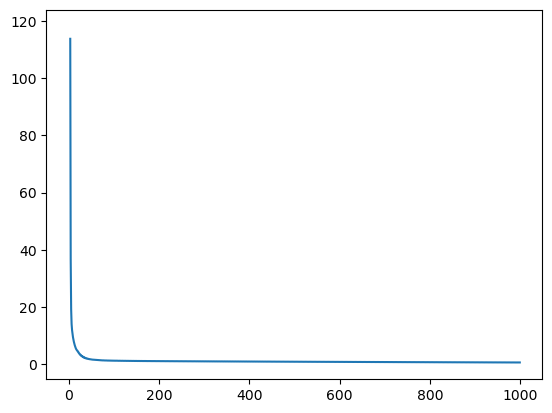

In [213]:
# plot the cost
plt.plot(costs)

In [214]:
lr3 = 1
parameters ,grads , costs= model(X_train_array, new_Y_train_array, layers_dims, learning_rate = lr3, activation = 'relu', num_iterations = iters2)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22324\3141600785.py:7: RuntimeWarning: divide by zero encountered in log
  cost = -(1./m) * np.sum(Y * np.log(AL))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22324\3141600785.py:7: RuntimeWarning: invalid value encountered in multiply
  cost = -(1./m) * np.sum(Y * np.log(AL))


In [215]:
costs

[118.04784416636089,
 nan,
 nan,
 36.374203088043906,
 2.143602817934386,
 1.558394487130532,
 1.4868638053281982,
 1.4572839397414667,
 1.4394358536821537,
 1.4268974857822052,
 1.417633721605565,
 1.4109928212446055,
 1.4062192341281767,
 1.4026254536107958,
 1.3996594983285957,
 1.3975696656733274,
 1.3959143070281135,
 1.3944905908954537,
 1.393178346142683,
 1.392068850493549,
 1.391076578320174,
 1.3901694779645386,
 1.389347907404327,
 1.3885778669832598,
 1.387825006480076,
 1.3871728821709934,
 1.3866475552443027,
 1.3861577756147518,
 1.3856875269687128,
 1.385240179176462,
 1.3848133243942566,
 1.3844126100174858,
 1.3840203095234211,
 1.3836678808340312,
 1.3833675286524343,
 1.3830798856521676,
 1.3828004306265789,
 1.382530508963934,
 1.3822874284093578,
 1.382053542262178,
 1.3818333699592085,
 1.3816168166574379,
 1.381409147981928,
 1.3812050152336575,
 1.3810025865020394,
 1.3808146284504894,
 1.3806414817380535,
 1.380472639451154,
 1.380305289499234,
 1.380140156391

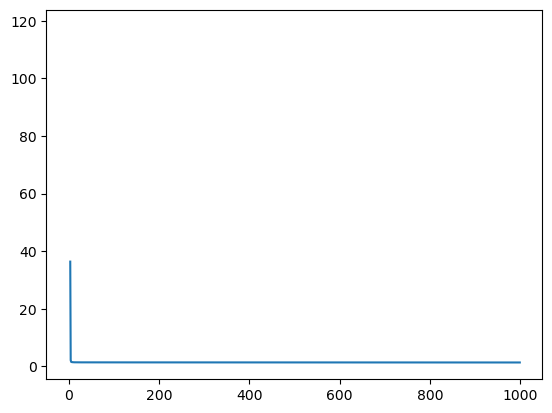

In [216]:
#plot the cost
plt.plot(costs)

In [217]:
lr4 = 0.001
parameters ,grads , costs= model(X_train_array, new_Y_train_array, layers_dims, learning_rate = lr4, activation = 'relu', num_iterations = iters2)

In [218]:
costs

[118.04784416636089,
 114.65138006980737,
 111.58615714526371,
 108.79923911569226,
 106.28791404117194,
 104.0235344609514,
 101.98322891570871,
 100.13082209417124,
 98.42888115369881,
 96.86115493784804,
 95.42272655456996,
 94.09166364602203,
 92.85773638504294,
 91.71097212979676,
 90.63756506170536,
 89.63438228717344,
 88.69481836561334,
 87.80856196362379,
 86.96905217620241,
 86.1738698528569,
 85.42198595802057,
 84.70761193393096,
 84.02404921777493,
 83.36638968178089,
 82.73465887321561,
 82.12887987785174,
 81.54437063887009,
 80.97675983849749,
 80.42445683708263,
 79.88644323304021,
 79.36156379086661,
 78.84884001902265,
 78.34777625346624,
 77.85786552373546,
 77.37879226840192,
 76.90986437602122,
 76.45012360543429,
 75.99843121473384,
 75.5546851703225,
 75.11849595334265,
 74.68921404819147,
 74.26630813284122,
 73.84954500723325,
 73.4388686443898,
 73.03400647274638,
 72.63455272316932,
 72.24007771946584,
 71.85028867041399,
 71.46498776392806,
 71.084102128533

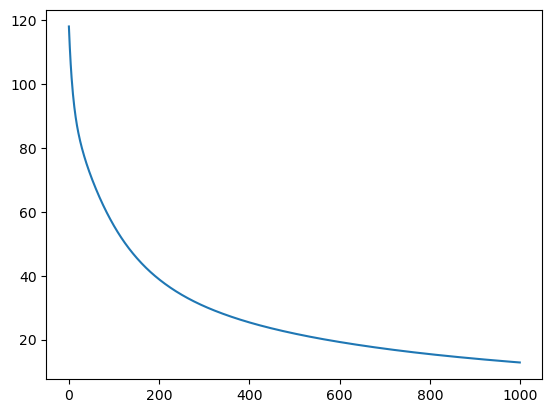

In [219]:
plt.plot(costs)